In [ ]:
!pip install shap
!pip install xgboost --upgrade #Gives more objectives to use

     |████████████████████████████████| 356 kB 9.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491651 sha256=52880d92c9f95eb77d8b1117d06d0c732d1b5a0a5005b9518dc7ace20bf77286
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
     |████████████████████████████████| 173.5 MB 67 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy import stats
import pickle
# from sklearn.preprocessing import PowerTransformer
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
housing = housing.drop(['date','zipcode'], axis=1)
housing = housing.query('price < 1272303')
housing['price'] = np.log(housing['price']) # If you set Gamma correctly you will see a major decrease in error if you Log the price.

In [ ]:
housing = housing.drop(['id'], axis=1) # We did this here so I we could potentially use ID to re-add two models back together

In [ ]:
X = housing.loc[:, housing.columns != 'price'] # Features are all the columns minus the target
y = housing.price

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.3, random_state=42)

model = XGBRegressor(learning_rate=0.1, objective='reg:squarederror', eval_metric='rmse',subsample = 0.6, seed = 3, reg_lambda = 20, n_estimators = 200, min_child_weight = 0, max_depth = 10, gamma = 0.1, colsample_bytree = 0.7)
# {'subsample': 0.6, 'seed': 3, 'reg_lambda': 20, 'n_estimators': 200, 'min_child_weight': 0, 'max_depth': 10, 'gamma': 0.1, 'colsample_bytree': 0.7} These are features provided by the RandomisedSearchCV
model.fit(X_train, y_train)
predictions = model.predict(X_test)
result = mean_squared_error(np.exp(y_test), np.exp(predictions), squared=False)
housing['price'] = np.exp(housing['price'])

In [ ]:
filename = 'housing_model.sav'
pickle.dump(model, open(filename, 'wb')) 

loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')
holdout = holdout.drop(['id', 'date','zipcode'], axis=1)
y_pred = loaded_model.predict(holdout)
y_pred = np.exp(y_pred)
np.savetxt("new_housing_data_predictions.csv", y_pred, delimiter=",")

# Denver's Tests and Colab

## Hyperparameters

This Initial code shown below is how I tuned the hyperparameters with a RandomSearch intead of a much longer to run grid search

In [ ]:
params = { 'subsample': [.1,.3,.5,.6,.8],
           'reg_lambda': [1, 3, 5,20,30],
           'n_estimators': [50,200, 500, 1000],
           'colsample_bytree': [0.3, 0.7],
            'max_depth': [3,6,7,8,10],
            'min_child_weight': [0,.1,.3,.5,.9,1,5,10,25,50,100],
            'seed': [0,1,3,7,10,50,100,1000],
          'gamma': [0,.1,.01,.001,.5,1,2,5,10]
}

In [ ]:
clf = RandomizedSearchCV(estimator=model, param_distributions = params, 
                   scoring='neg_mean_squared_error', 
                   verbose=3,
                   n_iter = 100)

In [1]:
clf.fit(X_train, y_train)

In [ ]:
print( clf.best_params_)
print('2')
print(clf.best_score_)

{'subsample': 0.8, 'seed': 1, 'reg_lambda': 20, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 7, 'gamma': 0.001, 'colsample_bytree': 0.7}
2
-0.027065029575818977


## SHAP

I discovered a sweet library called SHAP that allows you to see what the model makes its predictions off of. Basically allowing you to see within "The black box" [Go to the Shap library's github](https://colab.research.google.com/drive/1ednEUENs7XZ6FrLD_ni9YB7rIZBxftJ5?usp=sharing)

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


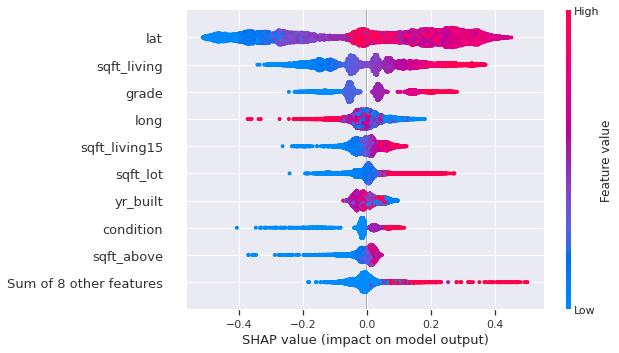

In [ ]:
shap.initjs() #This must be run before each shap plotting do initialize the javascript code it runs off of.
shap.plots.beeswarm(shap_values)

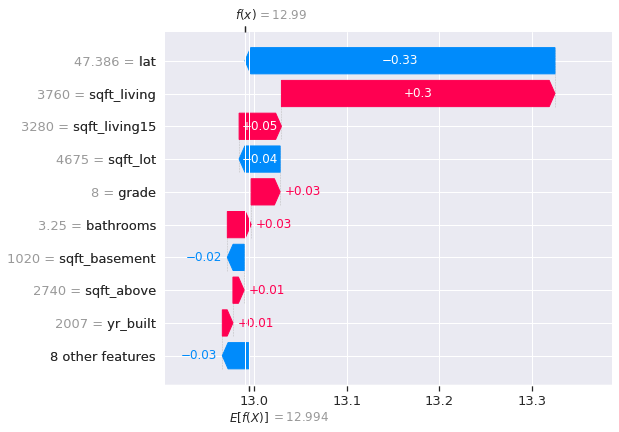

In [ ]:
shap.initjs() 
shap.plots.waterfall(shap_values[0])

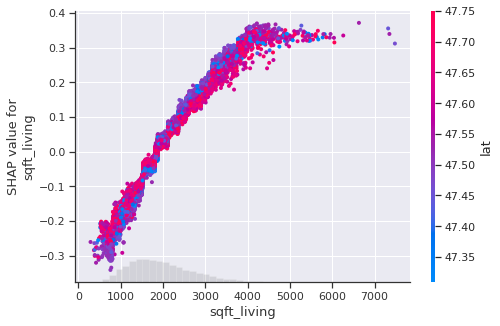

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"sqft_living"], color=shap_values)

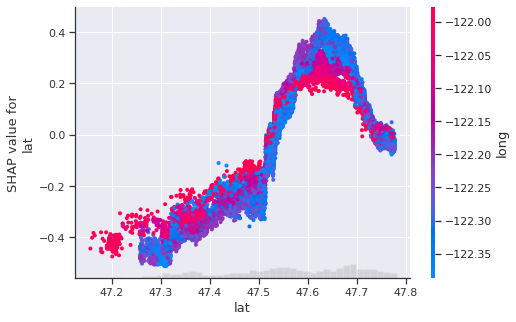

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"lat"], color=shap_values)

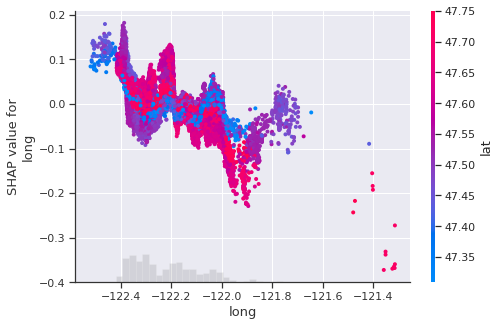

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"long"], color=shap_values)

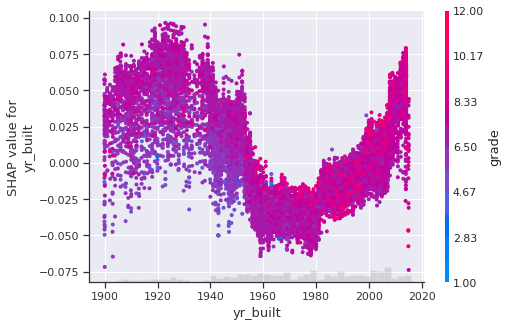

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"yr_built"], color=shap_values)

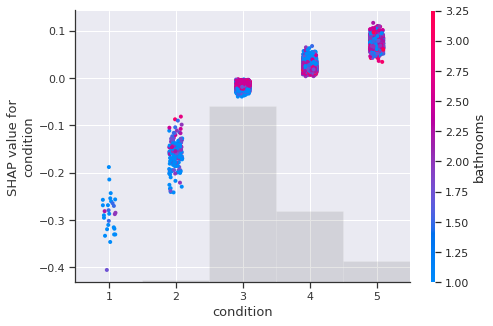

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"condition"], color=shap_values)

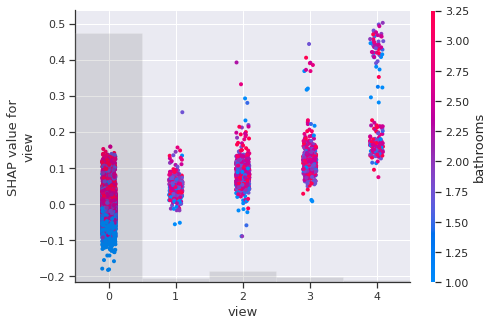

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"view"], color=shap_values)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0:5,:],X.iloc[0:5,:], plot_cmap="DrDb") # This one is interactive!

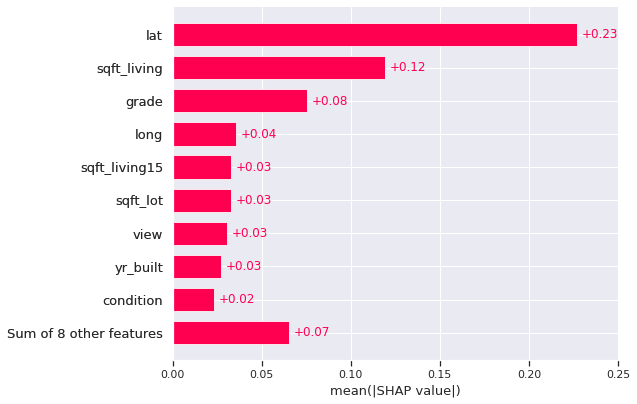

In [ ]:
shap.initjs()
shap.plots.bar(shap_values)

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])

## K-Nearest-Neighbors clustering of lat and long

In [ ]:
cluster_housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
X = cluster_housing.loc[:,['id','lat','long']]
kmeans = KMeans(n_clusters = 40, init ='k-means++')
kmeans.fit(X[['lat','long']]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[['lat','long']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[['lat','long']]) # Labels of each point
X.head(10)

id      lat     long  cluster_label
0  1565930130  47.3862 -122.048             28
1  3279000420  47.3035 -122.382             24
2   194000575  47.5658 -122.389             27
3  2115510160  47.3187 -122.390             24
4  7522500005  47.6859 -122.395             23
5  3787000140  47.7286 -122.168              1
6  7852110690  47.5389 -121.876              5
7  5469700260  47.3939 -122.177             17
8  8691410730  47.5970 -121.979              3
9   114100763  47.7639 -122.234             18

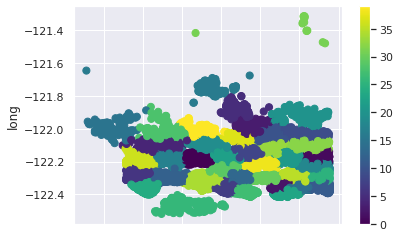

In [ ]:
X.plot.scatter(x = 'lat', y = 'long', c=labels, s=50, cmap='viridis')

In [2]:
X = X[['id','cluster_label']]
housing = housing.merge(X, left_on='id', right_on='id')
housing['cluster_label'] = pd.Categorical(housing['cluster_label'])

## [Go to the Denver's Testing Colab For the 3rd Case Study](https://colab.research.google.com/drive/1ednEUENs7XZ6FrLD_ni9YB7rIZBxftJ5?usp=sharing)






# Ben's Tests and Colab

Main code for testing model changes on

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")


housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv') 

In [ ]:
# housing['price'] = np.log(housing['price'])
# housing = housing.query('price < 1000000')
# lower, higher = housing['price'].min(), housing['price'].max()
# n_bins = 31
# edges = np.arange(lower, higher, (higher - lower)/n_bins)
# lbs = [((edges[i] + edges[i+1])/2) for i in range(len(edges)-1)]
# housing["price"] = pd.cut(housing['price'], bins=n_bins-1, labels=lbs, include_lowest=True)
# housing['yr_built'] = np.where((housing['yr_renovated'] != 0),
#                           housing['yr_renovated'],
#                           housing['yr_built'])
# housing = housing.drop(columns=['yr_built'])
housing = housing.drop(columns=['id','date'])
X = housing.loc[:,housing.columns != 'price']
y = housing['price']
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
# model = XGBRegressor()
model.fit(X_train, y_train)

In [ ]:
predictions = model.predict(X_test)

# result = mean_squared_error(np.exp(y_test), np.exp(predictions), squared=False)
result = mean_squared_error(y_test, predictions, squared=False)
result

Understanding the skew in our data, and attempting to fix it with log of the target

In [ ]:
import seaborn as sns
sns.histplot(data = housing, x = "price")

In [ ]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(data = housing, x = "price")

In [ ]:
mean = housing['price'].mean()
std = housing['price'].std()

print(mean + (std * 2))

max = (housing.price.mean() + (2 * housing.price.std()))

In [ ]:
housing['price'].skew() # Before, skew is 4. After, is .4

In [ ]:
housing['price'] = np.log(housing['price'])

In [ ]:
housing['price'] = np.exp(housing['price'])

Attempting to add geo-data to data

In [ ]:
# housing['location'] = geolocator.reverse(str(housing['lat'])+","+str(housing['long']))
# address = location.raw['address']
# print(str(housing['lat'])+","+str(housing['long']))
housing['location'] = housing.apply(lambda row: str(row.lat) + "," + str(row.long), axis=1)
housing['address'] = housing.apply(lambda row: geolocator.reverse(row.location).raw['address'], axis=1)

# Jacob's Tests and Colab

In [ ]:
# Binning the Pricing
# Didn't end up using because all it really did was artificially raise the 
# accuracy
df = housing

column = df["price"]
max_value = column.max()
target = max_value/5000
bins = [0]

initial_value = 0
while initial_value != max_value:
  initial_value += target
  bins.append(initial_value)

df["binned_price"] = pd.cut(df['price'], bins)

df["binned_price"] = df['binned_price'].astype(str)
df['binned_price'] = df['binned_price'].str.replace(']','')
df['binned_price'] = df['binned_price'].str.replace('(','')

pd.set_option('display.float_format', lambda x: '%.2f' % x)
temp_df = df['binned_price'].str.split(',', expand=True)
temp_df = temp_df.astype(float)
temp_df['price_window'] = temp_df.iloc[:, 0] + temp_df.iloc[:, 1]
temp_df['price_window'] = temp_df['price_window'] / 2
df["binned_price"] = temp_df['price_window']
df

# Caleb's Tests and Colab

I made some graphs and did some testing with models (both my own and my teammates), but the main thing I did was test if oversampling could help improve the model. To do this I separated the data into different price groups and then duplicated the items in each price group by a different amount. Ultimately this idea was scrapped due to concerns with overfitting.

#### Several of the graphs

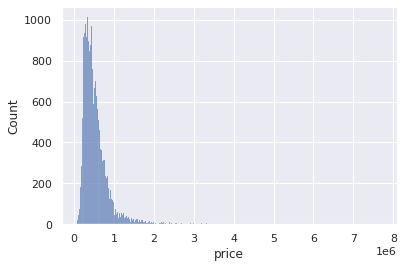

In [ ]:
caleb_housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
sns.histplot(data=caleb_housing, x="price", palette='mako')

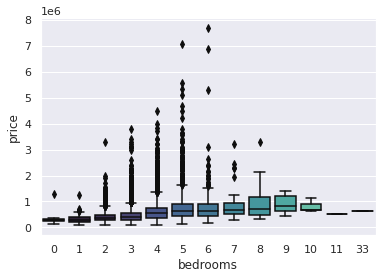

In [ ]:
sns.boxplot(y=caleb_housing["price"], x=caleb_housing["bedrooms"], palette='mako')

In [ ]:
caleb_housing["sqft_living_bins"] = pd.cut(x=caleb_housing["sqft_living"], bins=10)

In [ ]:
sns.boxplot(y=housing["price"], x=housing["sqft_living_bins"], palette='mako')

In [ ]:
sns.boxplot(y=housing["price"], x=housing["floors"], palette='mako')

In [ ]:
sns.boxplot(y=housing["price"], x=housing["waterfront"], palette='mako')

#### Duplicates creation and base model

In [ ]:
clean_housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

expensive_housing = clean_housing[clean_housing["price"] > 600000]
t600_m1_housing = expensive_housing[expensive_housing["price"] <= 1000000]

expensive_housing = clean_housing[clean_housing["price"] > 1000000]
m1_m1_5_housing = expensive_housing[expensive_housing["price"] <= 1500000]

expensive_housing = clean_housing[clean_housing["price"] > 1500000]
m1_5_m2_housing = expensive_housing[expensive_housing["price"] <= 2000000]

expensive_housing = clean_housing[clean_housing["price"] > 2000000]
m2_m3_housing = expensive_housing[expensive_housing["price"] <= 3000000]

expensive_housing = clean_housing[clean_housing["price"] > 3000000]
m3_m4_housing = expensive_housing[expensive_housing["price"] <= 4000000]

expensive_housing = clean_housing[clean_housing["price"] > 4000000]
m4_m5_housing = expensive_housing[expensive_housing["price"] <= 5000000]

expensive_housing = clean_housing[clean_housing["price"] > 5000000]
m5_m6_housing = expensive_housing[expensive_housing["price"] <= 6000000]

expensive_housing = clean_housing[clean_housing["price"] > 6000000]

In [ ]:
duplicate_housing = clean_housing

for i in range(2):
  duplicate_housing = duplicate_housing.append(t600_m1_housing, ignore_index=True)

for i in range(20):
  duplicate_housing = duplicate_housing.append(m1_m1_5_housing, ignore_index=True)

for i in range(40):
  duplicate_housing = duplicate_housing.append(m1_5_m2_housing, ignore_index=True)

for i in range(100):
  duplicate_housing = duplicate_housing.append(m2_m3_housing, ignore_index=True)

for i in range(100):
  duplicate_housing = duplicate_housing.append( m3_m4_housing, ignore_index=True)

for i in range(200):
  duplicate_housing = duplicate_housing.append(m4_m5_housing, ignore_index=True)

for i in range(200):
  duplicate_housing = duplicate_housing.append(m5_m6_housing, ignore_index=True)

for i in range(200):
  duplicate_housing = duplicate_housing.append(expensive_housing, ignore_index=True)

In [ ]:
sns.histplot(data=duplicate_housing, x="price", palette='mako')

In [ ]:
X_dup = pd.DataFrame({
    "bedrooms": duplicate_housing["bedrooms"],
    "bathrooms": duplicate_housing["bathrooms"],
    "sqft_living": duplicate_housing["sqft_living"],
    "sqft_lot": duplicate_housing["sqft_lot"],
    "floors": duplicate_housing["floors"],
    "waterfront": duplicate_housing["waterfront"],
    "view": duplicate_housing["view"],
    "condition": duplicate_housing["condition"],
    "grade": duplicate_housing["grade"],
    "sqft_above": duplicate_housing["sqft_above"],
    "sqft_basement": duplicate_housing["sqft_basement"],
    "yr_built": duplicate_housing["yr_built"],
    "yr_renovated": duplicate_housing["yr_renovated"],
    "zipcode": duplicate_housing["zipcode"],
    "lat": duplicate_housing["lat"],
    "long": duplicate_housing["long"],
    "sqft_living15": duplicate_housing["sqft_living15"],
    "sqft_lot15": duplicate_housing["sqft_lot15"]
})

Y_dup = pd.DataFrame({"price": duplicate_housing["price"]})

In [ ]:
X_dup_train, X_dup_test, y_dup_train, y_dup_test = train_test_split(X_dup, Y_dup, test_size=0.2, random_state=42)

In [ ]:
model_dup = XGBRegressor(learning_rate=0.2, max_depth=15)
model_dup.fit(X_dup_train, y_dup_train)

In [ ]:
dup_predictions = model_dup.predict(X_dup_test)
print(mean_squared_error(y_dup_test, dup_predictions, squared=False))

### [Go to Caleb's Testing Colab for 3rd Case Study](https://colab.research.google.com/drive/1FoO_mc3EQmE8LBJOdYgnYKkhrrK4CSQ1?authuser=1#scrollTo=2LfXAC5E6V3g)